# Multilayer Neural Network for Image Classification

We will use the multi-layer neural network for an image classification task.

## 0 - Preparation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage

The following files are auxiliary files for unit test. For copyright issues, they won't be provided in this repo. However, they only serve as testing purposes.

In [3]:
from dnn_app_utils_v3 import *
from public_tests import *

## 1 - Data Loading 

- The data includes a training set of many images labeled as cat (y=1) and non-cat (y=0) and a testing set of similar images.

- Each image has a shape of (number_pixel, number_pixel, 3), which represent picture width, height, RGB channels.

- For the copyright issue, the original dataset is not included in this repo.

In [4]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

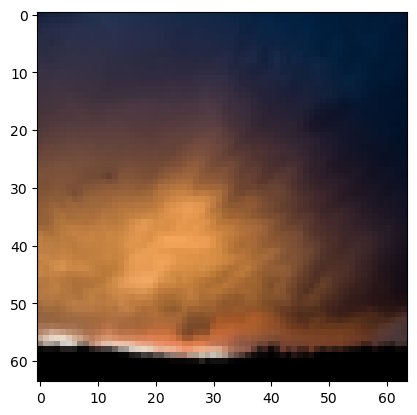

This is a 0


In [5]:
plt.imshow(train_x_orig[0])
plt.show()
print(f'This is a {train_y[0, 0]}')

## 2- Data Examination and Transform

Examine the data

In [6]:
train_x_orig.shape, train_y.shape, test_x_orig.shape, test_y.shape

((209, 64, 64, 3), (1, 209), (50, 64, 64, 3), (1, 50))

Each image should be transformed into a vector to be recognized by the neural network, so I will flatten the dataset.

In [7]:
num_train = train_x_orig.shape[0]
num_test = test_x_orig.shape[0]
train_x_flatten = train_x_orig.reshape((num_train, -1)).T
test_x_flatten = test_x_orig.reshape((num_test, -1)).T

Each pixel ranges from 0 to 255, so transform each pixel into 0 to 1

In [8]:
train_x = train_x_flatten / 255.0
test_x = test_x_flatten / 255.0

In [9]:
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((12288, 209), (1, 209), (12288, 50), (1, 50))

## 3 - Two-Layer Neural Network

For a two-layer neural netowrk (input layer is not counted), the input $X$ undergoes the following transformation

1st layer linear combination:
$$
Z^{[1]} = W^{[1]} \cdot X + \vec{b}^{[1]}
$$

1st layer activation:
$$
A^{[1]} = \text{relu}(Z^{[1]} )
$$

2nd layer linear combination:
$$
Z^{[2]} = W^{[2]} \cdot A ^{[1]} + \vec{b}^{[2]}
$$

2nd layer activation
$$
\hat{Y} = A^{[2]} = \text{sigmoid}(Z^{[2]} )
$$

The cross entropy function is used as the loss function:

$$
J = -1.0 \cdot \frac{1}{n} \sum_{i=1}^{n} (y^{(i)}\text{log}(\hat{y}^{(i)}) + (1-y^{(i)})\text{log}(1-\hat{y}^{(i)}))
$$

The backward propagation are calculated as follows:

Loss function:
$$
\frac{\partial J}{\partial A^{[2]}} = -1.0 \cdot (\frac{Y}{A^{[2]}} - \frac{1-Y}{1-A^{[2]}})
$$

Activation function at last layer:
$$
\frac{\partial J}{\partial Z^{[2]}} = \frac{\partial J}{\partial A^{[2]}} \cdot \frac{\partial A^{[2]}}{\partial Z^{[2]}} = A^{[2]} - Y
$$

Linear combination at last layer:
$$
\frac{\partial J}{\partial W^{[2]}} = \frac{\partial J}{\partial Z^{[2]}} \cdot \frac{\partial Z^{[2]}}{\partial W^{[2]}} = \frac{1}{n} (A^{[2]} - Y) A^{[1]T}
$$

$$
\frac{\partial J}{\partial \vec{b}^{[2]}} = \frac{\partial J}{\partial Z^{[2]}} \cdot \frac{\partial Z^{[2]}}{\partial \vec{b}^{[2]}} = \frac{1}{n} \text{sum} (A^{[2]} - Y)
$$

Activation function at 1st layer:
$$
\frac{\partial J}{\partial A^{[1]}} = \frac{\partial J}{\partial Z^{[2]}} \cdot \frac{\partial Z^{[2]}}{\partial A^{[1]}} = W^{[2]T} (A^{[2]} - Y) 
$$

$$
\frac{\partial J}{\partial Z^{[1]}} = \frac{\partial J}{\partial A^{[1]}} \cdot \frac{\partial A^{[1]}}{\partial Z^{[1]}} = W^{[2]T} (A^{[2]} - Y) \cdot \text{np.where}(Z^{[1]} > 0, 1, 0)
$$

Linear combination at 1st layer:
$$ 
\frac{\partial J}{\partial W^{[1]}} = \frac{\partial J}{\partial Z^{[1]}}  \frac{\partial Z^{[1]}}{\partial W^{[1]}} =  \frac{1}{n} \frac{\partial J}{\partial Z^{[1]}}  X^T
$$

$$ 
\frac{\partial J}{\partial \vec{b}^{[1]}} = \frac{\partial J}{\partial Z^{[1]}}  \frac{\partial Z^{[1]}}{\partial \vec{b}^{[1]}} =  \frac{1}{n} \text{sum}(\frac{\partial J}{\partial Z^{[1]}})
$$

`two_layer_model`: wrap the model into a function

In [10]:
def two_layer_model(X: np.ndarray, Y: np.ndarray, layers_dims: list[int], learning_rate: float=0.0075, num_iterations: int=3000):
    """
    Two-layer neural network: linear->relu->linear->sigmoid
    
    Arguments:
    X: (num_feature, num_samples)
    Y: (1, num_samples)
    layers_dims: [input_layer_size, hidden_layer_size, output_layer_size]
    num_iterations: maximum number of iterations for training loop
    learning_rate: float for adjust learning step
    
    Returns:
    parameters: {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
    """
    np.random.seed(1)
    grads = {}
    losses = [] 
    num_samples = X.shape[1] 
    (input_layer_size, hidden_layer_size, output_layer_size) = layers_dims
    # Initialize parameters
    parameters = initialize_parameters(input_layer_size, hidden_layer_size, output_layer_size)
    # Extract 
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    # Loop for training
    for i in range(0, num_iterations):
        # forward pass
        A1, cache1 = linear_activation_forward(X, W1, b1, 'relu')
        A2, cache2 = linear_activation_forward(A1, W2, b2, 'sigmoid')
        # compute the loss
        loss = compute_cost(A2, Y)
        # backward pass
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, 'sigmoid')
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, 'relu')
        # save into dict
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        # update the parameters
        parameters = update_parameters(parameters, grads, learning_rate) 
        # extract for next for loop
        W1 = parameters['W1']
        b1 = parameters['b1']
        W2 = parameters['W2']
        b2 = parameters['b2']
        # visualize training progress
        if i % 100 == 0 or i == num_iterations-1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(loss)))
            losses.append(loss)
    return parameters, losses

call the model function to train the model

In [11]:
parameters, costs = two_layer_model(train_x, train_y, layers_dims = (12288, 7, 1), num_iterations = 2500)

Cost after iteration 0: 0.6930497356599888
Cost after iteration 100: 0.6464320953428849
Cost after iteration 200: 0.6325140647912677
Cost after iteration 300: 0.6015024920354665
Cost after iteration 400: 0.5601966311605747
Cost after iteration 500: 0.5158304772764729
Cost after iteration 600: 0.4754901313943325
Cost after iteration 700: 0.4339163151225749
Cost after iteration 800: 0.4007977536203887
Cost after iteration 900: 0.3580705011323798
Cost after iteration 1000: 0.3394281538366413
Cost after iteration 1100: 0.3052753636196264
Cost after iteration 1200: 0.2749137728213015
Cost after iteration 1300: 0.24681768210614832
Cost after iteration 1400: 0.1985073503746611
Cost after iteration 1500: 0.17448318112556657
Cost after iteration 1600: 0.1708076297809737
Cost after iteration 1700: 0.113065245621647
Cost after iteration 1800: 0.09629426845937152
Cost after iteration 1900: 0.08342617959726865
Cost after iteration 2000: 0.07439078704319085
Cost after iteration 2100: 0.0663074813226

## 5 - Multi-Layer Neural Network

In [12]:
# Define layer dimension
layers_dims = [12288, 20, 7, 5, 1]

`multiple_layer_model`: wrap model into a function

In [22]:
def multiple_layer_model(X: np.ndarray, Y: np.ndarray, layers_dims: list[int], learning_rate: float=0.0075, num_iterations: int=3000):
    """
    Mutli-layer neural network: linear->relu->linear->relu->...->linear->sigmoid
    
    Arguments:
       X: (num_feature, num_samples)
    Y: (1, num_samples)
    layers_dims: [input_layer_size, hidden_layer_size, output_layer_size]
    num_iterations: maximum number of iterations for training loop
    learning_rate: float for adjust learning step
    
    Returns:
    parameters: {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
    """
    # Initialize parameters
    np.random.seed(1)
    losses = []
    parameters = initialize_parameters_deep(layers_dims)
    # Training loop for gradient descent
    for i in range(0, num_iterations):
        # forward pass
        AL, caches = L_model_forward(X, parameters)
        # calculate the loss
        loss = compute_cost(AL, Y)
        # backward pass
        grads = L_model_backward(AL, Y, caches)
        # update parameters
        parameters = update_parameters(parameters, grads, learning_rate)
        # Visualize the training process
        if i % 100 == 0 or i == num_iterations-1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(loss)))
            losses.append(loss)
    return parameters, losses

call the function to train the model

In [23]:
parameters, costs = multiple_layer_model(train_x, train_y, layers_dims, num_iterations = 2500)

Cost after iteration 0: 0.7717493284237686
Cost after iteration 100: 0.6720534400822914
Cost after iteration 200: 0.6482632048575212
Cost after iteration 300: 0.6115068816101354
Cost after iteration 400: 0.5670473268366111
Cost after iteration 500: 0.54013766345478
Cost after iteration 600: 0.5279299569455268
Cost after iteration 700: 0.46547737717668514
Cost after iteration 800: 0.3691258524959279
Cost after iteration 900: 0.39174697434805356
Cost after iteration 1000: 0.3151869888600615
Cost after iteration 1100: 0.27269984417893844
Cost after iteration 1200: 0.23741853400268137
Cost after iteration 1300: 0.19960120532208644
Cost after iteration 1400: 0.18926300388463305
Cost after iteration 1500: 0.1611885466582775
Cost after iteration 1600: 0.14821389662363316
Cost after iteration 1700: 0.13777487812972944
Cost after iteration 1800: 0.1297401754919012
Cost after iteration 1900: 0.12122535068005211
Cost after iteration 2000: 0.11382060668633712
Cost after iteration 2100: 0.107839285

## 6 - Post Model Analysis

Accuracy: 1.0


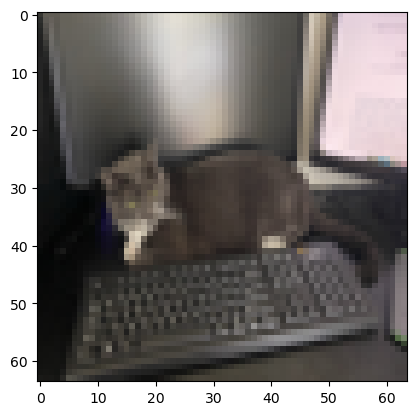

In [30]:
my_image = "my_cat1.jpeg"
my_label_y = [1]

fname = my_image
image = np.array(Image.open(fname).resize((64, 64)))
plt.imshow(image)
image = image / 255.
image = image.reshape((1, 64 * 64 * 3)).T

my_predicted_image = predict(image, my_label_y, parameters)